# Poroviscoelastic Tides of Io - Julia Notebook
### Hamish Hay (hamish.hay@earth.ox.ac.uk)

This is an accompanying Julia notebook to the paper "Poroviscoelastic Tides of Io" by Hay, Hewitt, Rovira-Navarro, and Katz. This notebook reproduces all figures in the manuscript.

In [1]:
include("../TidalLoveNumbersPorousK23.jl")
using .TidalLoveNumbers
using DoubleFloats
using PyPlot
using Statistics
using PyCall
using BenchmarkTools
using LinearAlgebra
    
@pyimport seaborn as sns
@pyimport matplotlib as mpl
@pyimport matplotlib.gridspec as gspec

PyPlot.isjulia_display[] = false;

PyPlot.matplotlib[:rc]("font",family="Arial", weight="medium", style="normal", size=12)
PyPlot.matplotlib[:rc]("axes",titlesize=14.5, labelsize=12, unicode_minus=false)
PyPlot.matplotlib[:rc]("xtick",labelsize=11.5)
PyPlot.matplotlib[:rc]("ytick",labelsize=11.5)
PyPlot.matplotlib[:rc]("pdf",fonttype=42)
PyPlot.matplotlib[:rc]("mathtext", fontset = "stix")

#mpl.style.use("dark_background")

# Get precision of love number calculations
prec = TidalLoveNumbers.prec    # Real
precc = TidalLoveNumbers.precc; # Complex

IO_OBVS = ((9.33-1.87)*1e13, (9.33+1.87)*1e13)

(7.46e13, 1.12e14)

In [2]:
# Convenience function for returning internal structure based on 
# asthensphere thickness
function get_internal_structure(asthenosphere_thickness)    # Input is in km
    R = 1820.0
    r_cmb = 700.0
    r_crust = 1800.0
    r_asthenosphere = r_crust - asthenosphere_thickness

    return [0, r_cmb, r_asthenosphere, r_crust, R] .* 1e3
end;

# Convenience function to calculate the complex moduli for a 
# poroviscoelastic compacting material
function get_complex_moduli(μ, η, κd, ζ, κs, ω)
    μc = zeros(precc, length(μ))
    κdc = zero(μc)
    αc = zero(μc)
    
    for i in 1:length(μ) 
        μc[i]  =  isinf(η[i]) ? μ[i] : 1im*ω*μ[i] / (1im*ω + μ[i] / η[i])
        κdc[i] =  isinf(ζ[i]) ? κd[i] : 1im*ω*κd[i] / (1im*ω + κd[i] / ζ[i])
        αc[i]  = 1.0 - κdc[i] / κs[i]
    end
    
    return μc, κdc, αc
end

get_complex_moduli (generic function with 1 method)

## Define main material parameters for each layer

In [3]:
nr = 200
n = 2
ω = 2 * 2.05e-5
ecc = 0.0048
nr_coarse = 50
nr_fine   = 250

# Solid material parameters -------------------------------------------
ρs = prec[3300, 3300, 3300, 3300]   # Solid density
μ = prec[60, 60, 60, 60] .* 1e9     # Shear modulus
κs = prec[100, 200, 200, 200].*1e9  # Solid bulk modulus
η = prec[1e25, 1e25, 1e30, 1e25]    # Solid shear viscosity
ζ = prec[1e25, 1e25, 1e0, 1e25]    # Solid compaction viscosity

# Liquid/two-phase material parameters --------------------------------
ρl = [0, 0, 3300, 0]                # Liquid density
κl = [0, 0, 100e9, 0]    # Liquid bulk modulus
κd = 0.01κs                         # Drained bulk modulus
k = [0, 0, 1e-7, 0]                 # Permeability
α = 1.0 .- κd ./ κs                    # Biot's modulus

ηl = [0, 0, 1, 0]                 # Liquid viscosity
ϕ =  [0, 0, prec(0.1), 0]           # Porosity

ρ = (1 .- ϕ) .* ρs + ϕ .* ρl        # Bulk density

D = 50                            # Asthenosphere thickness in km
r = get_internal_structure(D)       # Internal structure

R = r[end]                          # Mean radius 
rr = expand_layers(r, nr=nr)        # Discretize primary layers into secondary layers
g = get_g(rr, ρ);                   # Calculate g at each secondary layer#

define_spherical_grid(10.0);

# Total Heating Rate

## vs. Mobility

In [7]:
ηl = [0, 0, 1.0, 0]
k = [0, 0, 1e-8, 0]

ks = [-8:0.1:-1.9, -9:0.1:-1.9, -9:0.1:-1.9, -9:0.1:-1.9] 
Kls = [1, 10, 200, 1e21] * 1e9

κds = [0.99κs, 0.01κs]

# vol_3 = 4/3. * π * (r[4]^3 - r[3]^3)

El = [[zeros(length(ks[i])) for i in 1:length(Kls)] for j in 1:length(κds)]

D = 50.0                              # Asthenosphere thickness in km
r = get_internal_structure(D)       # Internal structure
rr = expand_layers(r, nr=nr_coarse)        # Discretize primary layers into secondary layers
g = get_g(rr, ρ);   
vol_3 = 4/3. * π * (r[4]^3 - r[3]^3) 

for x in 1:length(κds)
    κd = κds[x]
    α  = 1.0 .- κd ./ κs
    for j in 1:length(Kls)
        κl[3] = Kls[j]
        for i in 1:length(ks[j])
            k[3] = 10.0^ks[j][i]
            y1 = calculate_y(rr, ρ, g, μ, κs, ω, ρl, κl, κd, α, ηl, ϕ, k);
            y1 = ComplexF64.(y1)

            E1, E2, E3 = get_heating_profile(y1, rr, ρ, g, μ, κs, ω, ρl, κl, κd, α, ηl, ϕ, k, ecc)

            
            # Etotal[i] = get_total_heating(y1, ω, R, ecc)
            El[x][j][i] = E3[1][3]* vol_3
        end
    end
end

D = 50
ks2 = [-9.0, -8.0, -7.0, -6.0]# Asthenosphere thickness in km
El_prof = zeros((nr_fine+1, 4, length(ks2)))
El_prof_total = zeros((length(ks2)))
r = get_internal_structure(D)       # Internal structure
rr = expand_layers(r, nr=nr_fine)        # Discretize primary layers into secondary layers
g = get_g(rr, ρ); 
κd = 0.01κs
α  = 1 .- κd ./ κs 
κl = [0.0, 0.0, 1e30, 0.0]



for i in 1:length(ks2)
    k[3] = 10.0^ks2[i]
    y1 = calculate_y(rr, ρ, g, μ, κs, ω, ρl, κl, κd, α, ηl, ϕ, k);
    y1 = ComplexF64.(y1)

    E1, E2, E3 = get_heating_profile(y1, rr, ρ, g, μ, κs, ω, ρl, κl, κd, α, ηl, ϕ, k, ecc)

    
    El_prof[:,:,i] = E3[2]
    El_prof_total[i] = E3[1][3]* vol_3
    
end

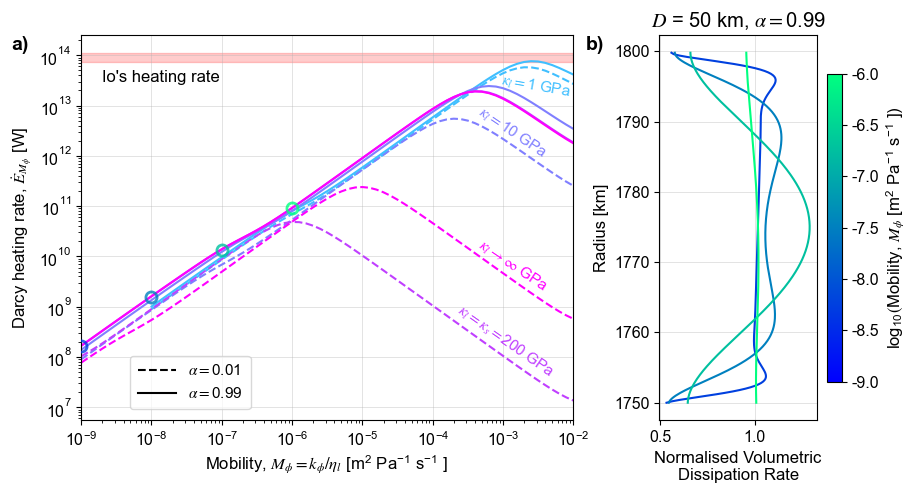

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [8]:
fig, (ax1, ax2) = subplots(ncols=2, width_ratios=[1, 0.4], figsize=(10, 5))

#, label="\$D\$ = $(Ds[j]) km"

cmap = PyPlot.cm.cool;
ims = []
ls = ["--", "-"]
for i in 1:length(κds)
    for j in 1:length(Kls)
        lineplot, = ax1.loglog((10 .^ ks[j]) ./ ηl[3], El[i][j][:], ls=ls[i], color=cmap(j/length(Kls)))  
        push!(ims, lineplot)
    end
end

ax1.set_ylabel("Darcy heating rate, \$\\dot{E}_{M_\\phi}\$ [W]")
ax1.set_xlabel("Mobility, \$M_\\phi = k_\\phi / \\eta_l \$ [m\$^\\mathregular{2}\$ Pa\$^{\\mathregular{-1}}\$ s\$^{\\mathregular{-1}}\$ ] ")

ax1.axhspan(IO_OBVS[1], IO_OBVS[2], color="red", alpha=0.2)
ax1.text(2e-9, 3e13, "Io's heating rate", fontsize=12)
ax1.set_xlim(1e-9, 1e-2)
ax1.legend(ncols=2, columnspacing=0.0)

line_dash = mpl.lines.Line2D([0], [0], label="\$\\alpha = \\mathregular{0.01}\$", color="k", linestyle="--")
line_solid = mpl.lines.Line2D([0], [0], label="\$\\alpha = \\mathregular{0.99}\$", color="k", linestyle="-")
handles, labels = ax1.get_legend_handles_labels()
handles = [handles; [line_dash, line_solid]]

ax1.legend(handles=handles, handlelength=2.5,
          columnspacing=2, borderpad=0.5, framealpha=0.75,prop=Dict("size" => 11),
            loc=(0.1,0.03))



# extra = mpl.patches.Rectangle((0, 0), 1, 1, fc="w", fill=false, edgecolor="none", linewidth=0)
# legend_handle = [extra, extra, extra, extra, extra, ims[1], ims[2], ims[3], extra, ims[4], ims[5], ims[6]]
# label_col_1 = ["", "\$D = \\mathregular{10}\$ km", 
#                    "\$D = \\mathregular{50}\$ km", 
#                    "\$D = \\mathregular{300}\$ km"]
# label_j_1 = ["\$\\alpha = \\mathregular{0.01}\$"]
# label_j_2 = ["\$\\alpha = \\mathregular{0.99}\$"]
# label_empty = [""]

# #organize labels for table construction
# legend_labels = [label_col_1; label_j_1; repeat(label_empty, 3); label_j_2; repeat(label_empty, 3)]

# ax1.legend(legend_handle, legend_labels, 
#           ncol = 3, handletextpad = -3, handlelength=2.5,
#           columnspacing=2, borderpad=1, framealpha=0.75,prop=Dict("size" => 10),
#             loc=(0.02,0.55))


ax1.grid(which="major", alpha=0.5, linewidth=0.5)


cmap2 = PyPlot.cm.winter;
for i in 1:length(ks2)
    ax2.plot(El_prof[1:end-1,3,i]/(El_prof_total[i]/vol_3), rr[1:end-1,3]/1e3, color=cmap2(i/length(ks2)))
    ax1.plot(10 .^ Float64(ks2[i]) ./ ηl[3], El_prof_total[i], "o", color=cmap2(i/length(ks2)), alpha=0.8, ms=8,zorder=20, markerfacecolor="None", markeredgewidth=2)

end

ax2.set_xlabel("Normalised Volumetric\nDissipation Rate")
ax2.set_ylabel("Radius [km]")
# ax2.set_xlim(0.4, 1.1)
ax2.grid(which="both", alpha=0.5, linewidth=0.5)
ax2.set_title("\$D\$ = 50 km, \$\\alpha = \\mathregular{0.99}\$")

# # TODO - make a function to do this step
tick_loc = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
ax1.xaxis.set_major_locator(mpl.ticker.FixedLocator(tick_loc)) 
ax1.set_xticklabels(["10\$^{\\mathregular{$(i)}}\$" for i in -9:1:-2]) 

# ax1.text(3e16, 1.7e3, "\$\\kappa_l = \\mathregular{0.1}\$ GPa", rotation=-32, color=cmap(1/5), fontsize=11)
ax1.text(9e-4, 1.5e13, "\$\\kappa_l = \\mathregular{1}\$ GPa", rotation=-10, color=cmap(1/4), fontsize=11)
ax1.text(4e-4, 9e11, "\$\\kappa_l = \\mathregular{10}\$ GPa", rotation=-34, color=cmap(2/4), fontsize=11)
ax1.text(2e-4, 4e7, "\$\\kappa_l = \\kappa_s = \\mathregular{200}\$ GPa", rotation=-35, color=cmap(3/4), fontsize=11)
ax1.text(4e-4, 2e9, "\$\\kappa_l \\rightarrow \\infty\$ GPa", rotation=-34, color=cmap(4/4), fontsize=11)


# tick_loc = [1e7, 1e8, 1e9, 1e10, 1e11, 1e12, 1e13, 1e14]
# ax1.yaxis.set_major_locator(mpl.ticker.FixedLocator(tick_loc)) 
# ax1.set_yticklabels(["10\$^{\\mathregular{7}}\$", "10\$^{\\mathregular{8}}\$", "10\$^{\\mathregular{9}}\$", "10\$^{\\mathregular{10}}\$", "10\$^{\\mathregular{11}}\$", "10\$^{\\mathregular{12}}\$", "10\$^{\\mathregular{13}}\$", "10\$^{\\mathregular{14}}\$"])

norm = mpl.colors.Normalize(vmin=ks2[1], vmax=ks2[end])
sm = PyPlot.cm.ScalarMappable(cmap=cmap2, norm=norm)
colorbar(sm, shrink=0.8, label="log\$_{\\mathregular{10}} (\$Mobility, \$M_\\phi\$ [m\$^\\mathregular{2}\$ Pa\$^{\\mathregular{-1}}\$ s\$^{\\mathregular{-1}}\$ ]) ")

subplots_adjust(wspace=0.25)

fig.text(0.055, 0.85, "a)", fontsize=14, fontweight="bold")
fig.text(0.63, 0.85, "b)", fontsize=14, fontweight="bold")

fig.savefig("./figures/fig1_mobility_v_heat.pdf", bbox_inches="tight")#

display(fig)

### vs Bulk Modulus

In [11]:
ηl = [0, 0, 1, 0]
k = [0, 0, 1e-7, 0]

# ks = [-11:0.1:-2.9, -10:0.1:-2.9, -8:0.1:-2.9]
ζs = 13:0.2:22.1

κs = [100.0, 100.0, 200.0, 100.0] * 1e9
κl = [100.0, 100.0, 100, 100.0] * 1e9


Kls = [0.1, 1, 10, 200, 1e21] * 1e9

κds = [0.99κs, 0.01κs]
# κds = [0.99κs, κs.*(1-0.1)]

El = [[zeros(length(ζs)) for i in 1:length(Kls)] for x in 1:length(κds)]
El2 = [[zeros(length(ζs)) for i in 1:length(Kls)] for x in 1:length(κds)]

D = 50.0                              # Asthenosphere thickness in km
r = get_internal_structure(D)       # Internal structure
rr = expand_layers(r, nr=nr_coarse)        # Discretize primary layers into secondary layers
g = get_g(rr, ρ);    
vol_3 = 4/3. * π * (r[4]^3 - r[3]^3)

for x in 1:length(κds)
    κd[3] = κds[x][3]
    
    for j in 1:length(Kls)
        κl[3] = Kls[j]
        for i in 1:length(ζs)
            ζ[3] = 10.0^ζs[i]

            μc, κdc, αc = get_complex_moduli(μ, η, κd, ζ, κs, ω)
            y1 = calculate_y(rr, ρ, g, μ, κs, ω, ρl, κl, κdc, αc, ηl, ϕ, k);
            y1 = ComplexF64.(y1)

            E1, E2, E3 = get_heating_profile(y1, rr, ρ, g, μ, κs, ω, ρl, κl, κdc, αc, ηl, ϕ, k, ecc)
            
            El[x][j][i] = E2[1][3]* vol_3
        end
    end
end

# k = prec[0,0,5e-8,0]
# for x in 1:length(κds)
#     κd[3] = κds[x][3]
    
#     for j in 1:length(Kls)
#         κl[3] = Kls[j]
#         for i in 1:length(ζs)
#             ζ[3] = 10.0^ζs[i]

#             μc, κdc, αc = get_complex_moduli(μ, η, κd, ζ, κs, ω)
#             y1 = calculate_y(rr, ρ, g, μ, κs, ω, ρl, κl, κdc, αc, ηl, ϕ, k);
#             y1 = ComplexF64.(y1)

#             E1, E2, E3, E4 = get_heating_profile(y1, rr, ρ, g, μ, κs, ω, ρl, κl, κdc, αc, ηl, ϕ, k, ecc)
            
#             El2[x][j][i] = E4[1][3]* vol_3
#         end
#     end
# end



D = 50
ζs2 = [13, 16, 19, 22]# Asthenosphere thickness in km
El_prof = zeros((nr_fine+1, 4, length(ζs2)))
El_prof_total = zeros((length(ζs2)))
r = get_internal_structure(D)       # Internal structure
rr = expand_layers(r, nr=nr_fine)        # Discretize primary layers into secondary layers
g = get_g(rr, ρ); 
κd = zero(κs)
κd[3] = 0.99κs[3] 
α  = 1 .- κd ./ κs 


for i in 1:length(ζs2)
    ζ[3] = 10.0^ζs2[i]
    κl[3] = Kls[end]
    μc, κdc, αc = get_complex_moduli(μ, η, κd, ζ, κs, ω)
    y1 = calculate_y(rr, ρ, g, μ, κs, ω, ρl, κl, κdc, αc, ηl, ϕ, k);
    y1 = ComplexF64.(y1)

    E1, E2, E3 = get_heating_profile(y1, rr, ρ, g, μ, κs, ω, ρl, κl, κdc, αc, ηl, ϕ, k, ecc)

    
    El_prof[:,:,i] = E2[2]
    El_prof_total[i] = E2[1][3]* vol_3
    
end

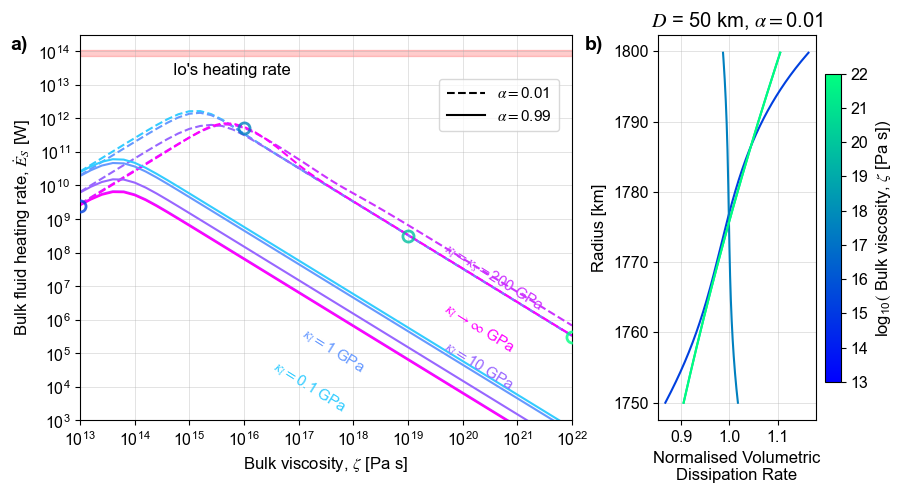

In [12]:
fig, (ax1, ax2) = subplots(ncols=2, width_ratios=[1, 0.4], figsize=(10, 5))

#, label="\$D\$ = $(Ds[j]) km"

cmap = PyPlot.cm.cool;
ims1 = []
ls = ["--", "-"]
for x in 1:length(κds)
    for j in 1:length(Kls)
        # ζ[3] = 10.0^ζs
        τ = 10.0 .^ ζs * ω/ (κds[x][3] )
        # lineplot, = ax1.loglog( τ, El[x][j][:], color=cmap(j/length(Ds)))  
        lineplot, = ax1.loglog( 10.0.^ζs, El[x][j][:], ls=ls[x], color=cmap(j/length(Kls)))
        # lineplot, = ax2.loglog( 10.0.^ζs, El2[x][j][:], ls=ls[x], color=cmap(j/length(Kls)))
        push!(ims1, lineplot)
    end
end

ax1.set_ylabel("Bulk fluid heating rate, \$\\dot{E}_S\$ [W]")
ax1.set_xlabel("Bulk viscosity, \$\\zeta\$ [Pa s]")

ax1.axhspan(IO_OBVS[1], IO_OBVS[2], color="red", alpha=0.2)
ax1.text(5e14, 2e13, "Io's heating rate", fontsize=12)
# ax1.set_xlim(1e-11, 1e-3)
# ax1.legend(ncols=2, columnspacing=0.0)

line_dash = mpl.lines.Line2D([0], [0], label="\$\\alpha = \\mathregular{0.01}\$", color="k", linestyle="--")
line_solid = mpl.lines.Line2D([0], [0], label="\$\\alpha = \\mathregular{0.99}\$", color="k", linestyle="-")
handles, labels = ax1.get_legend_handles_labels()
handles = [handles; [line_dash, line_solid]]
ax1.legend(handles=handles)

# extra = mpl.patches.Rectangle((0, 0), 1, 1, fc="w", fill=false, edgecolor="none", linewidth=0)
# legend_handle = [extra, extra, extra, extra, extra, extra, extra, ims1[1], ims1[2], ims1[3], ims1[4], ims1[5], extra, ims1[6], ims1[7], ims1[8], ims1[9], ims1[10]]
# label_col_1 = ["","\$D = \\mathregular{50}\$ km", 
#                    "\$D = \\mathregular{300}\$ km"]
# label_col_1 = ["","\$\\kappa_l = \\mathregular{0.1}\$ GPa", 
#                    "\$\\kappa_l = \\mathregular{1}\$ GPa",
#                    "\$\\kappa_l = \\mathregular{10}\$ GPa",
#                    "\$\\kappa_l = \\mathregular{200}\$ GPa",
#                    "\$\\kappa_l \\rightarrow \\infty\$"]
# label_j_1 = ["\$\\alpha = \\mathregular{0.01}\$"]
# label_j_2 = ["\$\\alpha = \\mathregular{0.99}\$"]
# label_empty = [""]

# # organize labels for table construction
# legend_labels = [label_col_1; label_j_1; repeat(label_empty, 5); label_j_2; repeat(label_empty, 5)]

ax1.legend(handles=handles, handlelength=2.5,
          columnspacing=2, borderpad=0.5, framealpha=0.75,prop=Dict("size" => 11),
            loc=(0.73,0.75))


ax1.grid(which="both", alpha=0.5, linewidth=0.5)


cmap2 = PyPlot.cm.winter;
for i in 1:length(ζs2)
    ax2.plot(El_prof[1:end-1,3,i]/(El_prof_total[i]/vol_3), rr[1:end-1,3]/1e3, color=cmap2(i/length(ζs2)))
    ax1.plot(10 .^ Float64(ζs2[i]), El_prof_total[i], "o", color=cmap2(i/length(ζs2)), alpha=0.8, ms=8,zorder=20, markerfacecolor="None", markeredgewidth=2)

end

ax2.set_xlabel("Normalised Volumetric\nDissipation Rate")
ax2.set_ylabel("Radius [km]")

ax2.grid(which="both", alpha=0.5, linewidth=0.5)
ax2.set_title("\$D\$ = 50 km, \$\\alpha = \\mathregular{0.01}\$")

# TODO - make a function to do this step
tick_loc = [1e13, 1e14, 1e15, 1e16, 1e17, 1e18, 1e19, 1e20, 1e21, 1e22]
ax1.xaxis.set_major_locator(mpl.ticker.FixedLocator(tick_loc)) 
ax1.set_xticklabels(["10\$^{\\mathregular{$(i)}}\$" for i in 13:1:22])

tick_loc = [1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10, 1e11, 1e12, 1e13, 1e14]
ax1.yaxis.set_major_locator(mpl.ticker.FixedLocator(tick_loc)) 
ax1.set_yticklabels(["10\$^{\\mathregular{$(i)}}\$" for i in 3:1:14])
ax1.set_ylim(1e3, 3e14)
# ax2.set_ylim(1e3, 3e14)
ax1.set_xlim(1e13, 1e22)

norm = mpl.colors.Normalize(vmin=ζs2[1], vmax=ζs2[end])
sm = PyPlot.cm.ScalarMappable(cmap=cmap2, norm=norm)
colorbar(sm, shrink=0.8, label="log\$_{\\mathregular{10}} (\$ Bulk viscosity, \$\\zeta\$ [Pa s]) ")

subplots_adjust(wspace=0.25)

fig.text(0.055, 0.85, "a)", fontsize=14, fontweight="bold")
fig.text(0.63, 0.85, "b)", fontsize=14, fontweight="bold")
ax1.text(3e16, 1.7e3, "\$\\kappa_l = \\mathregular{0.1}\$ GPa", rotation=-32, color=cmap(1/5), fontsize=11)
ax1.text(1e17, 2.6e4, "\$\\kappa_l = \\mathregular{1}\$ GPa", rotation=-32, color=cmap(2/5), fontsize=11)
ax1.text(4e19, 8e3, "\$\\kappa_l = \\mathregular{10}\$ GPa", rotation=-32, color=cmap(3/5), fontsize=11)
ax1.text(4e19, 1.8e6, "\$\\kappa_l = \\kappa_s = \\mathregular{200}\$ GPa", rotation=-32, color=cmap(4/5), fontsize=11)
ax1.text(4e19, 1e5, "\$\\kappa_l \\rightarrow \\infty\$ GPa", rotation=-32, color=cmap(5/5), fontsize=11)

fig.savefig("./figures/fig2_bulk_visc_v_heat.pdf", bbox_inches="tight")#

display(fig)

## Bulk viscosity and solid heating rate

In [ ]:
ηl = [0, 0, 1, 0]
k = [0, 0, 1e-7, 0]

# ks = [-11:0.1:-2.9, -10:0.1:-2.9, -8:0.1:-2.9]
ζs = 13:0.2:22.1

κs = [100.0, 100.0, 200.0, 100.0] * 1e9
κl = [100.0, 100.0, 100, 100.0] * 1e9


Kls = [1, 10, 1e21] * 1e9

κds = [0.99κs, 0.01κs]



Es = [[zeros(length(ζs)) for i in 1:length(Kls)] for x in 1:length(κds)]
E_nomelt = zeros(length(ζs))
# El2 = [[zeros(length(ζs)) for i in 1:length(Kls)] for x in 1:length(κds)]

D = 50                              # Asthenosphere thickness in km
r = get_internal_structure(D)       # Internal structure
rr = expand_layers(r, nr=nr_coarse)        # Discretize primary layers into secondary layers
g = get_g(rr, ρ);    

vol_3 = 4/3. * π * (r[4]^3 - r[3]^3)

for x in 1:length(κds)
    κd[3] = κds[x][3]
    
    for j in 1:length(Kls)
        κl[3] = Kls[j]
        for i in 1:length(ζs)
            ζ[3] = 10.0^ζs[i]

            μc, κdc, αc = get_complex_moduli(μ, η, κd, ζ, κs, ω)

            
            y1 = calculate_y(rr, ρ, g, μ, κs, ω, ρl, κl, κdc, αc, ηl, ϕ, k);
            y1 = ComplexF64.(y1)

            E1, E2, E3 = get_heating_profile(y1, rr, ρ, g, μ, κs, ω, ρl, κl, κdc, αc, ηl, ϕ, k, ecc)
            
            Es[x][j][i] = E2[1][3]* vol_3


            if (x==1 && j==1) 
                μc, κsc, αc = get_complex_moduli(μ, η, κs, ζ, κs, ω)
                y1 = calculate_y(rr, ρ, g, μ, κsc);
                y1 = ComplexF64.(y1)    

                E1, E2 = get_heating_profile(y1, rr, ρ, g, μ, κsc, ω, ecc)
                E_nomelt[i] = E2[1][3]* vol_3
            end
            # println(κdc[3], " ", Es[x][j][i])
        end
    end
end

D = 50
ζs2 = [13, 15, 17, 19]# Asthenosphere thickness in km
Es_prof = zeros((nr_fine+1, 4, length(ζs2)))
Es_prof_total = zeros((length(ζs2)))

r = get_internal_structure(D)       # Internal structure
rr = expand_layers(r, nr=nr_fine)        # Discretize primary layers into secondary layers
g = get_g(rr, ρ); 

κd = zero(κs)
κd[3] = 0.99κs[3] 
α  = 1 .- κd ./ κs 


for i in 1:length(ζs2)
    ζ[3] = 10.0^ζs2[i]
    κl[3] = Kls[1]
    μc, κdc, αc = get_complex_moduli(μ, η, κd, ζ, κs, ω)
    y1 = calculate_y(rr, ρ, g, μ, κs, ω, ρl, κl, κdc, αc, ηl, ϕ, k);
    y1 = ComplexF64.(y1)

    E1, E2, E3 = get_heating_profile(y1, rr, ρ, g, μ, κs, ω, ρl, κl, κdc, αc, ηl, ϕ, k, ecc)

    
    Es_prof[:,:,i] = E2[2]
    Es_prof_total[i] = E2[1][3]* vol_3
    
end

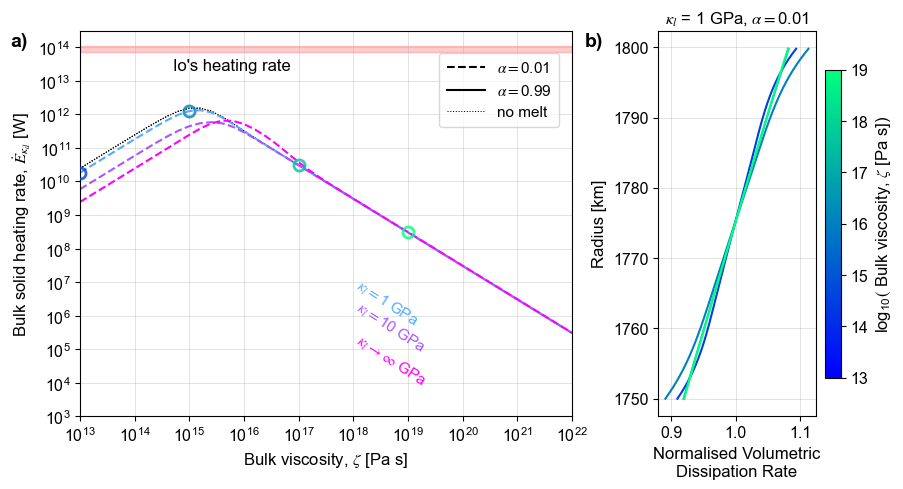

In [21]:
fig, (ax1, ax2) = subplots(ncols=2, width_ratios=[1, 0.4], figsize=(10, 5))

#, label="\$D\$ = $(Ds[j]) km"

cmap = PyPlot.cm.cool;
ims1 = []
ls = ["--", "-"]
for x in 1:length(κds)
    for j in 1:length(Kls)
        # ζ[3] = 10.0^ζs
        τ = 10.0 .^ ζs * ω/ (κds[x][3] )
        # lineplot, = ax1.loglog( τ, El[x][j][:], color=cmap(j/length(Ds)))  
        lineplot, = ax1.loglog( 10.0.^ζs, Es[x][j][:], ls=ls[x], color=cmap(j/length(Kls)))
        ax1.plot(10 .^ ζs, E_nomelt, "k:", linewidth=0.75, zorder=-5)
        # lineplot, = ax2.loglog( 10.0.^ζs, Es2[x][j][:], ls=ls[x], color=cmap(j/length(Kls)))
        push!(ims1, lineplot)
    end
end

ax1.set_ylabel("Bulk solid heating rate, \$\\dot{E}_{\\kappa_d}\$ [W]")
ax1.set_xlabel("Bulk viscosity, \$\\zeta\$ [Pa s]")

ax1.axhspan(IO_OBVS[1], IO_OBVS[2], color="red", alpha=0.2)
ax1.text(5e14, 2e13, "Io's heating rate", fontsize=12)
# ax1.set_xlim(1e-11, 1e-3)
# ax1.legend(ncols=2, columnspacing=0.0)

line_dash = mpl.lines.Line2D([0], [0], label="\$\\alpha = \\mathregular{0.01}\$", color="k", linestyle="--")
line_solid = mpl.lines.Line2D([0], [0], label="\$\\alpha = \\mathregular{0.99}\$", color="k", linestyle="-")
line_dotted = mpl.lines.Line2D([0], [0], label="no melt", color="k", linestyle=":", linewidth=0.75)
handles, labels = ax1.get_legend_handles_labels()
handles = [handles; [line_dash, line_solid, line_dotted]]
ax1.legend(handles=handles)

ax1.legend(handles=handles, handlelength=2.5,
          columnspacing=2, borderpad=0.5, framealpha=0.75,prop=Dict("size" => 11),
            loc=(0.73,0.75))


ax1.grid(which="both", alpha=0.5, linewidth=0.5)

cmap2 = PyPlot.cm.winter;
for i in 1:length(ζs2)
    ax2.plot(Es_prof[1:end-1,3,i]/(Es_prof_total[i]/vol_3), rr[1:end-1,3]/1e3, color=cmap2(i/length(ζs2)))
    ax1.plot(10 .^ Float64(ζs2[i]), Es_prof_total[i], "o", color=cmap2(i/length(ζs2)), alpha=0.8, ms=8,zorder=20, markerfacecolor="None", markeredgewidth=2)

end

ax2.set_xlabel("Normalised Volumetric\nDissipation Rate")
ax2.set_ylabel("Radius [km]")

ax2.grid(which="both", alpha=0.5, linewidth=0.5)
ax2.set_title("\$\\kappa_l\$ = 1 GPa, \$\\alpha = \\mathregular{0.01}\$", fontsize=12)

# TODO - make a function to do this step
tick_loc = [1e13, 1e14, 1e15, 1e16, 1e17, 1e18, 1e19, 1e20, 1e21, 1e22]
ax1.xaxis.set_major_locator(mpl.ticker.FixedLocator(tick_loc)) 
ax1.set_xticklabels(["10\$^{\\mathregular{$(i)}}\$" for i in 13:1:22])

tick_loc = [1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10, 1e11, 1e12, 1e13, 1e14]
ax1.yaxis.set_major_locator(mpl.ticker.FixedLocator(tick_loc)) 
ax1.set_yticklabels(["10\$^{\\mathregular{$(i)}}\$" for i in 3:1:14])
ax1.set_ylim(1e3, 3e14)
# ax2.set_ylim(1e3, 3e14)
ax1.set_xlim(1e13, 1e22)

norm = mpl.colors.Normalize(vmin=ζs2[1], vmax=ζs2[end])
sm = PyPlot.cm.ScalarMappable(cmap=cmap2, norm=norm)
colorbar(sm, shrink=0.8, label="log\$_{\\mathregular{10}} (\$ Bulk viscosity, \$\\zeta\$ [Pa s]) ")

subplots_adjust(wspace=0.25)

fig.text(0.055, 0.85, "a)", fontsize=14, fontweight="bold")
fig.text(0.63, 0.85, "b)", fontsize=14, fontweight="bold")
# ax1.text(3e16, 1.7e3, "\$\\kappa_l = \\mathregular{0.1}\$ GPa", rotation=-32, color=cmap(1/5), fontsize=11)
ax1.text(1e18, 5e5, "\$\\kappa_l = \\mathregular{1}\$ GPa", rotation=-33, color=cmap(1/3), fontsize=11)
ax1.text(1e18, 8e4, "\$\\kappa_l = \\mathregular{10}\$ GPa", rotation=-33, color=cmap(2/3), fontsize=11)
# ax1.text(4e19, 1.8e6, "\$\\kappa_l = \\kappa_s = \\mathregular{200}\$ GPa", rotation=-32, color=cmap(3/4), fontsize=11)
ax1.text(1e18, 8e3, "\$\\kappa_l \\rightarrow \\infty\$ GPa", rotation=-33, color=cmap(3/3), fontsize=11)

fig.savefig("./figures/fig3_bulk_visc_v_heat.pdf", bbox_inches="tight")#

display(fig)

# Pressure vs bulk viscosity

In [ ]:
ηl = [0, 0, 1, 0]
k = [0, 0, 1e-7, 0]

# ks = [-11:0.1:-2.9, -10:0.1:-2.9, -8:0.1:-2.9]
ζs = 13:0.2:22.1

κs = [100.0, 100.0, 200.0, 100.0] * 1e9
κl = [100.0, 100.0, 100, 100.0] * 1e9


Kls = [1, 10, 1e21] * 1e9

κds = [0.99κs, 0.01κs]



Ps = [[zeros(length(ζs)) for i in 1:length(Kls)] for x in 1:length(κds)]
E_nomelt = zeros(length(ζs))
# El2 = [[zeros(length(ζs)) for i in 1:length(Kls)] for x in 1:length(κds)]

D = 50                              # Asthenosphere thickness in km
r = get_internal_structure(D)       # Internal structure
rr = expand_layers(r, nr=nr_coarse)        # Discretize primary layers into secondary layers
g = get_g(rr, ρ);    

vol_3 = 4/3. * π * (r[4]^3 - r[3]^3)

for x in 1:length(κds)
    κd[3] = κds[x][3]
    
    for j in 1:length(Kls)
        κl[3] = Kls[j]
        for i in 1:length(ζs)
            ζ[3] = 10.0^ζs[i]

            μc, κdc, αc = get_complex_moduli(μ, η, κd, ζ, κs, ω)

            y1 = calculate_y(rr, ρ, g, μ, κs, ω, ρl, κl, κdc, αc, ηl, ϕ, k);
            y1 = ComplexF64.(y1)

            Ps[x][j][i] = mean(abs.(y1[7,:,end-1]))

        end
    end
end


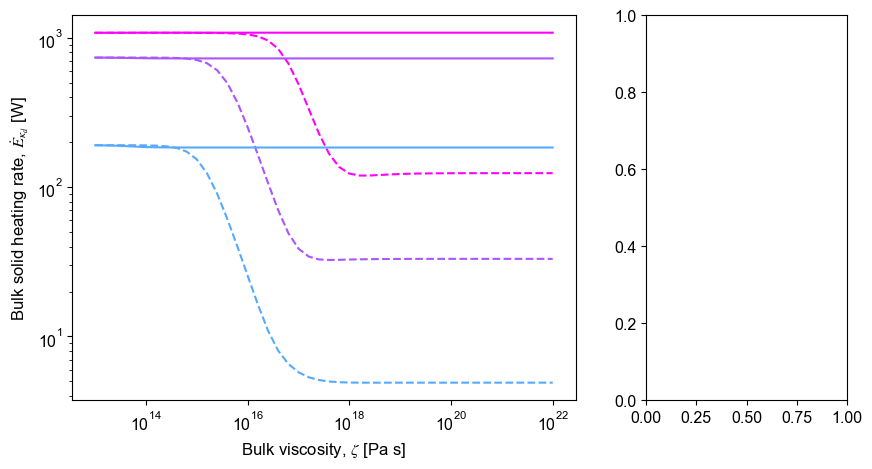

In [24]:
fig, (ax1, ax2) = subplots(ncols=2, width_ratios=[1, 0.4], figsize=(10, 5))

#, label="\$D\$ = $(Ds[j]) km"

cmap = PyPlot.cm.cool;
ims1 = []
ls = ["--", "-"]
for x in 1:length(κds)
    for j in 1:length(Kls)
        # ζ[3] = 10.0^ζs
        τ = 10.0 .^ ζs * ω/ (κds[x][3] )
        # lineplot, = ax1.loglog( τ, El[x][j][:], color=cmap(j/length(Ds)))  
        lineplot, = ax1.loglog( 10.0.^ζs, Ps[x][j][:], ls=ls[x], color=cmap(j/length(Kls)))
        # ax1.plot(10 .^ ζs, E_nomelt, "k:", linewidth=0.75, zorder=-5)
        # lineplot, = ax2.loglog( 10.0.^ζs, Es2[x][j][:], ls=ls[x], color=cmap(j/length(Kls)))
        push!(ims1, lineplot)
    end
end

ax1.set_ylabel("Bulk solid heating rate, \$\\dot{E}_{\\kappa_d}\$ [W]")
ax1.set_xlabel("Bulk viscosity, \$\\zeta\$ [Pa s]")

# ax1.axhspan(IO_OBVS[1], IO_OBVS[2], color="red", alpha=0.2)
# ax1.text(5e14, 2e13, "Io's heating rate", fontsize=12)
# # ax1.set_xlim(1e-11, 1e-3)
# # ax1.legend(ncols=2, columnspacing=0.0)

# line_dash = mpl.lines.Line2D([0], [0], label="\$\\alpha = \\mathregular{0.01}\$", color="k", linestyle="--")
# line_solid = mpl.lines.Line2D([0], [0], label="\$\\alpha = \\mathregular{0.99}\$", color="k", linestyle="-")
# line_dotted = mpl.lines.Line2D([0], [0], label="no melt", color="k", linestyle=":", linewidth=0.75)
# handles, labels = ax1.get_legend_handles_labels()
# handles = [handles; [line_dash, line_solid, line_dotted]]
# ax1.legend(handles=handles)

# ax1.legend(handles=handles, handlelength=2.5,
#           columnspacing=2, borderpad=0.5, framealpha=0.75,prop=Dict("size" => 11),
#             loc=(0.73,0.75))


# ax1.grid(which="both", alpha=0.5, linewidth=0.5)

# cmap2 = PyPlot.cm.winter;
# for i in 1:length(ζs2)
#     ax2.plot(Es_prof[1:end-1,3,i]/(Es_prof_total[i]/vol_3), rr[1:end-1,3]/1e3, color=cmap2(i/length(ζs2)))
#     ax1.plot(10 .^ Float64(ζs2[i]), Es_prof_total[i], "o", color=cmap2(i/length(ζs2)), alpha=0.8, ms=8,zorder=20, markerfacecolor="None", markeredgewidth=2)

# end

# ax2.set_xlabel("Normalised Volumetric\nDissipation Rate")
# ax2.set_ylabel("Radius [km]")

# ax2.grid(which="both", alpha=0.5, linewidth=0.5)
# ax2.set_title("\$\\kappa_l\$ = 1 GPa, \$\\alpha = \\mathregular{0.01}\$", fontsize=12)

# # TODO - make a function to do this step
# tick_loc = [1e13, 1e14, 1e15, 1e16, 1e17, 1e18, 1e19, 1e20, 1e21, 1e22]
# ax1.xaxis.set_major_locator(mpl.ticker.FixedLocator(tick_loc)) 
# ax1.set_xticklabels(["10\$^{\\mathregular{$(i)}}\$" for i in 13:1:22])

# tick_loc = [1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10, 1e11, 1e12, 1e13, 1e14]
# ax1.yaxis.set_major_locator(mpl.ticker.FixedLocator(tick_loc)) 
# ax1.set_yticklabels(["10\$^{\\mathregular{$(i)}}\$" for i in 3:1:14])
# ax1.set_ylim(1e3, 3e14)
# # ax2.set_ylim(1e3, 3e14)
# ax1.set_xlim(1e13, 1e22)

# norm = mpl.colors.Normalize(vmin=ζs2[1], vmax=ζs2[end])
# sm = PyPlot.cm.ScalarMappable(cmap=cmap2, norm=norm)
# colorbar(sm, shrink=0.8, label="log\$_{\\mathregular{10}} (\$ Bulk viscosity, \$\\zeta\$ [Pa s]) ")

# subplots_adjust(wspace=0.25)

# fig.text(0.055, 0.85, "a)", fontsize=14, fontweight="bold")
# fig.text(0.63, 0.85, "b)", fontsize=14, fontweight="bold")
# # ax1.text(3e16, 1.7e3, "\$\\kappa_l = \\mathregular{0.1}\$ GPa", rotation=-32, color=cmap(1/5), fontsize=11)
# ax1.text(1e18, 5e5, "\$\\kappa_l = \\mathregular{1}\$ GPa", rotation=-33, color=cmap(1/3), fontsize=11)
# ax1.text(1e18, 8e4, "\$\\kappa_l = \\mathregular{10}\$ GPa", rotation=-33, color=cmap(2/3), fontsize=11)
# # ax1.text(4e19, 1.8e6, "\$\\kappa_l = \\kappa_s = \\mathregular{200}\$ GPa", rotation=-32, color=cmap(3/4), fontsize=11)
# ax1.text(1e18, 8e3, "\$\\kappa_l \\rightarrow \\infty\$ GPa", rotation=-33, color=cmap(3/3), fontsize=11)

# fig.savefig("./figures/fig3_bulk_visc_v_heat.pdf", bbox_inches="tight")#

display(fig)

### Solid heating vs shear viscosity

In [31]:
ηl = [0, 0, 1, 0]
k = [0, 0, 5e-7, 0]

# ks = [-11:0.1:-2.9, -10:0.1:-2.9, -8:0.1:-2.9]
# ζs = 13:0.2:22.1
ηs = 9:0.25:22.1

κs = [100.0, 100.0, 200.0, 100.0] * 1e9
κl = [100.0, 100.0, 100, 100.0] * 1e9


Kls = [1] * 1e9

κds = [0.99κs, 0.01κs]



Es = [[zeros(length(ηs)) for i in 1:length(Kls)] for x in 1:length(κds)]
E_nomelt = zeros(length(ηs))
# El2 = [[zeros(length(ηs)) for i in 1:length(Kls)] for x in 1:length(κds)]

D = 300                              # Asthenosphere thickness in km
r = get_internal_structure(D)       # Internal structure
rr = expand_layers(r, nr=nr_coarse)        # Discretize primary layers into secondary layers
g = get_g(rr, ρ);    

vol_3 = 4/3. * π * (r[4]^3 - r[3]^3)

for x in 1:length(κds)
    κd[3] = κds[x][3]
    
    for j in 1:length(Kls)
        κl[3] = Kls[j]
        for i in 1:length(ηs)
            η[3] = 10.0^ηs[i]

            μc, κdc, αc = get_complex_moduli(μ, η, κd, ζ, κs, ω)
            μc[1] = μ[1]
            μc[2] = μ[2]
            μc[4] = μ[4]

            
            y1 = calculate_y(rr, ρ, g, μc, κs, ω, ρl, κl, κdc, αc, ηl, ϕ, k);
            y1 = ComplexF64.(y1)

            E1, E2, E3, E4 = get_heating_profile(y1, rr, ρ, g, μc, κs, ω, ρl, κl, κdc, αc, ηl, ϕ, k, ecc)
            
            Es[x][j][i] = E1[1][3]* vol_3

            if (x==1 && j==1) 
                μc, κsc, αc = get_complex_moduli(μ, η, κs, ζ, κs, ω)
                y1 = calculate_y(rr, ρ, g, μc, κsc);
                y1 = ComplexF64.(y1)    

                E1, E2 = get_heating_profile(y1, rr, ρ, g, μc, κsc, ω, ecc)
                E_nomelt[i] = E1[1][3]* vol_3
            end
        end
    end
end

D = 300
ηs2 = [9, 12, 15, 18]# Asthenosphere thickness in km
Es_prof = zeros((nr_fine+1, 4, length(ηs2)))
Es_prof_total = zeros((length(ηs2)))

r = get_internal_structure(D)       # Internal structure
rr = expand_layers(r, nr=nr_fine)        # Discretize primary layers into secondary layers
g = get_g(rr, ρ); 

κd = zero(κs)
κd[3] = 0.01κs[3] 
α  = 1 .- κd ./ κs 

for i in 1:length(ηs2)
    η[3] = 10.0^ηs2[i]
    κl[3] = Kls[1]
    μc, κdc, αc = get_complex_moduli(μ, η, κd, ζ, κs, ω)
    y1 = calculate_y(rr, ρ, g, μc, κs, ω, ρl, κl, κd, α, ηl, ϕ, k);
    y1 = ComplexF64.(y1)

    E1, E2, E3, E4 = get_heating_profile(y1, rr, ρ, g, μc, κs, ω, ρl, κl, κd, α, ηl, ϕ, k, ecc)

    
    Es_prof[:,:,i] = E1[2]
    Es_prof_total[i] = E1[1][3]* vol_3
    
end

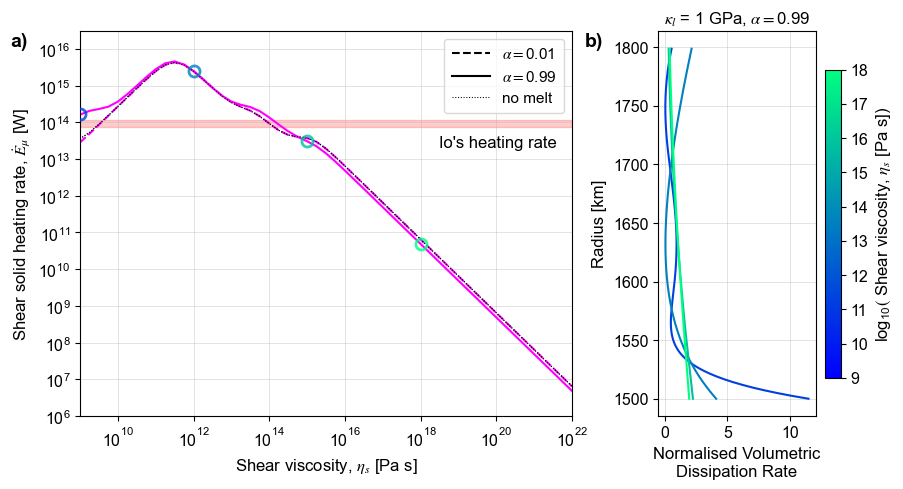

In [33]:
fig, (ax1, ax2) = subplots(ncols=2, width_ratios=[1, 0.4], figsize=(10, 5))

#, label="\$D\$ = $(Ds[j]) km"

cmap = PyPlot.cm.cool;
ims1 = []
ls = ["--", "-"]
for x in 1:length(κds)
    for j in 1:length(Kls)
        # ζ[3] = 10.0^ζs
        # τ = 10.0 .^ ζs * ω/ (κds[x][3] )
        # lineplot, = ax1.loglog( τ, El[x][j][:], color=cmap(j/length(Ds)))  
        lineplot, = ax1.loglog( 10.0.^ηs, Es[x][j][:], ls=ls[x], color=cmap(j/length(Kls)))
        ax1.plot(10 .^ ηs, E_nomelt, "k:", linewidth=0.75)
        # lineplot, = ax2.loglog( 10.0.^ζs, Es2[x][j][:], ls=ls[x], color=cmap(j/length(Kls)))
        push!(ims1, lineplot)
    end
end

ax1.set_ylabel("Shear solid heating rate, \$\\dot{E}_{\\mu}\$ [W]")
ax1.set_xlabel("Shear viscosity, \$\\eta_s\$ [Pa s]")

ax1.axhspan(IO_OBVS[1], IO_OBVS[2], color="red", alpha=0.2)
ax1.text(3e18, 2e13, "Io's heating rate", fontsize=12)
# ax1.set_xlim(1e-11, 1e-3)
# ax1.legend(ncols=2, columnspacing=0.0)

line_dash = mpl.lines.Line2D([0], [0], label="\$\\alpha = \\mathregular{0.01}\$", color="k", linestyle="--")
line_solid = mpl.lines.Line2D([0], [0], label="\$\\alpha = \\mathregular{0.99}\$", color="k", linestyle="-")
line_dotted = mpl.lines.Line2D([0], [0], label="no melt", color="k", linestyle=":", linewidth=0.75)
handles, labels = ax1.get_legend_handles_labels()
handles = [handles; [line_dash, line_solid, line_dotted]]
ax1.legend(handles=handles)

ax1.legend(handles=handles, handlelength=2.5,
          columnspacing=2, borderpad=0.5, framealpha=0.75,prop=Dict("size" => 11))

ax1.grid(which="both", alpha=0.5, linewidth=0.5)

cmap2 = PyPlot.cm.winter;
for i in 1:length(ηs2)
    ax2.plot(Es_prof[1:end-1,3,i]/(Es_prof_total[i]/vol_3), rr[1:end-1,3]/1e3, color=cmap2(i/length(ηs2)))
    ax1.plot(10 .^ Float64(ηs2[i]), Es_prof_total[i], "o", color=cmap2(i/length(ηs2)), alpha=0.8, ms=8,zorder=20, markerfacecolor="None", markeredgewidth=2)

end

ax2.set_xlabel("Normalised Volumetric\nDissipation Rate")
ax2.set_ylabel("Radius [km]")

ax2.grid(which="both", alpha=0.5, linewidth=0.5)
ax2.set_title("\$\\kappa_l\$ = 1 GPa, \$\\alpha = \\mathregular{0.99}\$", fontsize=12)

# TODO - make a function to do this step
# tick_loc = [1e13, 1e14, 1e15, 1e16, 1e17, 1e18, 1e19, 1e20, 1e21, 1e22]
# ax1.xaxis.set_major_locator(mpl.ticker.FixedLocator(tick_loc)) 
# ax1.set_xticklabels(["10\$^{\\mathregular{$(i)}}\$" for i in 13:1:22])

tick_loc = [1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10, 1e11, 1e12, 1e13, 1e14, 1e15, 1e16]
ax1.yaxis.set_major_locator(mpl.ticker.FixedLocator(tick_loc)) 
ax1.set_yticklabels(["10\$^{\\mathregular{$(i)}}\$" for i in 3:1:16])
ax1.set_ylim(1e6, 3e16)
# ax2.set_ylim(1e3, 3e14)
ax1.set_xlim(1e9, 1e22)

norm = mpl.colors.Normalize(vmin=ηs2[1], vmax=ηs2[end])
sm = PyPlot.cm.ScalarMappable(cmap=cmap2, norm=norm)
colorbar(sm, shrink=0.8, label="log\$_{\\mathregular{10}} (\$ Shear viscosity, \$\\eta_s\$ [Pa s]) ")

subplots_adjust(wspace=0.25)

fig.text(0.055, 0.85, "a)", fontsize=14, fontweight="bold")
fig.text(0.63, 0.85, "b)", fontsize=14, fontweight="bold")
# ax1.text(3e16, 1.7e3, "\$\\kappa_l = \\mathregular{0.1}\$ GPa", rotation=-32, color=cmap(1/5), fontsize=11)
# ax1.text(1e18, 5e5, "\$\\kappa_l = \\mathregular{1}\$ GPa", rotation=-33, color=cmap(1/3), fontsize=11)
# ax1.text(1e18, 2.5e4, "\$\\kappa_l = \\mathregular{10}\$ GPa", rotation=-33, color=cmap(2/3), fontsize=11)
# # ax1.text(4e19, 1.8e6, "\$\\kappa_l = \\kappa_s = \\mathregular{200}\$ GPa", rotation=-32, color=cmap(3/4), fontsize=11)
# ax1.text(1e18, 4e3, "\$\\kappa_l \\rightarrow \\infty\$ GPa", rotation=-33, color=cmap(3/3), fontsize=11)

fig.savefig("./figures/fig4_shear_visc_v_solid_heat.pdf", bbox_inches="tight")#

display(fig)

# Appendix
## Numerical Instability

Hypothesis - the onset of numerical ill-conditioning is a consequence of the compaction length approaching too small a fraction of the porous layer thickness. 

In [204]:
nr = 100

# Solid material parameters -------------------------------------------
ρs = prec[3300, 3300, 3300, 3300]   # Solid density
μ = prec[60, 60, 60, 60] .* 1e9     # Shear modulus
κs = prec[100, 100, 100, 100].*1e9  # Solid bulk modulus
η = prec[1e25, 1e25, 1e15, 1e25]    # Solid shear viscosity
ζ = prec[1e25, 1e25, 1e25, 1e25]    # Solid compaction viscosity

# Liquid/two-phase material parameters --------------------------------
ρl = [0, 0, 3300, 0]                # Liquid density
κl = [0, 0, 100e9, 0]    # Liquid bulk modulus
κd = 0.05κs                         # Drained bulk modulus
k = [0, 0, 1e-8, 0]                 # Permeability
α = 1.0 .- κd/κs                    # Biot's modulus

ηl = [0, 0, 1, 0]                 # Liquid viscosity
ϕ =  [0, 0, prec(0.1), 0]           # Porosity

ρ = (1 .- ϕ) .* ρs + ϕ .* ρl        # Bulk density

Ds = 10:20:701
ks = -5:-0.05:-11
ηls = [1.0, 10.0, 100.0]

ηls = [ω*0.1, ω, ω*10]


k2 = zeros(ComplexF64, (length(ηls), length(ks), length(Ds)) )

for j2 in 1:length(ηls)
    # ηl = [0, 0, ηls[j2], 0]
    ω0 = ηls[j2]
    for j in 1:length(ks)
        k = [0, 0, 10^ks[j], 0]
        for i in 1:length(Ds)
            D = Ds[i]                              # Asthenosphere thickness in km
            r = get_internal_structure(D)       # Internal structure
                    
            rr = expand_layers(r, nr=nr)        # Discretize primary layers into secondary layers
            g = get_g(rr, ρ);    

            try 
                y1 = ComplexF64.(calculate_y(rr, ρ, g, μ, κs, ω0, ρl, κl, κd, α, ηl, ϕ, k));
                k2[j2, j, i] = y1[5,end,end]-1
            catch
                k2[j2, j, i] = 10.0
                continue
            end
        end
    end
end


In [218]:
failure = zeros((length(ηls), length(Ds)))
for j2 in 1:length(ηls)
    for i in 1:length(Ds)
        avg = abs(k2[j2, 1, i])
        for j in 2:length(ks)
            if abs(k2[j2, j,i]) > (1+0.001)*avg 
                failure[j2, i] = ks[j]
                break
            end
            avg = sum(abs.(k2[j2, 1:j, i]))/j
        end
    end
end

failure = zeros((length(ηls), length(Ds)))
for j2 in 1:length(ηls)
    for i in 1:length(Ds)
        avg = abs(k2[j2, 1, i])
        for j in 2:length(ks)
            diff = abs(abs(k2[j2, j,i]) - abs(k2[j2, j-1, i])) / abs(k2[j2, j-1, i]) 
            if diff  > 0.01  
                failure[j2, i] = ks[j]
                break
            end
            avg = sum(abs.(k2[j2, 1:j, i]))/j
        end
    end
end

In [ ]:
fig, ax = subplots()
for i in 1:length(ηls)
    ind = failure[i,:] .< 0.0
    S = 0.1/κl[3] + (α[3] - 0.1) / κs[3]
    compact_len_fail = sqrt.(10 .^ failure[i,:] ./ (ηls[i] * S * ηl[3]))
    # compact_len_fail = sqrt.(η[3] .* 10 .^ failure[i,:] ./ ηls[i])
    # ax.plot(Ds[ind], compact_len_fail[ind], "o", alpha=0.7, label="\$\\eta_l = $(
    #     (ηls[i]))\$ Pa s")
    ax.plot(Ds[ind], compact_len_fail[ind], "o", alpha=0.7, label="\$\\omega = $(
            (ηls[i]))\$ rad s\$^{-1}\$")
end
ax.grid(which="both")
ax.set_ylabel("Compaction length, \$\\delta\$ [m] \nat numerical stability limit")
ax.set_xlabel("Asthenosphere thickness, D [km]")
ax.legend()
ax.text(0.71, 0.32, "unstable", transform=ax.transAxes)
ax.fill_between(Ds, 14 .* Ds, color="gray", alpha=0.2)
ax.plot(Ds, 14 .* Ds, "k--", alpha=0.5)
fig.savefig("./figures/compact_vs_asthenosphere_thickness.pdf", bbox_inches="tight")
display(fig)

In [ ]:
fig, ax = subplots()
# for i in 1:length(ks)
#     ax.semilogy(Ds, abs.(k2[2,i,:]))
# end
ax.semilogy(Ds, abs.(k2[2,1,:]))
# ax.set_xlim(0, 111)
display(fig)